# **MÓDULO 27 - Projeto de Doenças Cardiovasculares - Regressão Logística**


Assim como na aula que trabalhamos com uma base de dados nova, com um contexto de modelo de propensão a compra de carros, para a atividade de vocês achei interessante trazer também novos desafios.

Nessa tarefa iremos construir um modelo que nos ajude a prever doenças cardiovasculares, a base contém dados reais.

age - idade dos pacientes

gender - genero (2 mulheres) (1 homens)

height - altura dos pacientes

weight - peso dos pacientes

gluc - glicose

smoke - fumante (1) não fumante (0)

alco - consume alcool (1) não consome (0)

active - realiza atividades fisicas (1) não realiza (0)

cardio_disease - tem doença cardio (1) não tem (0) - Variável target


Seu objetivo é utilizar esses dados históricos dos pacientes e construir um bom modelo de regressão capaz de indicar se novos pacientes estão propensos a doenças cariovasculares ou não.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, classification_report

# 1) Comece carregando e tratando a base de dados.
Assim como na aula essa nova base não passou por pré processamento nenhum então nessa etapa, carrega os dados, verifique os tipos de dados, verifique se temos dados faltantes e outliers.
Quando necessário realize o tratamento.


In [3]:
base = pd.read_csv("CARDIO_BASE.csv", delimiter=';')
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             10000 non-null  int64 
 1   gender          10000 non-null  int64 
 2   height          10000 non-null  int64 
 3   weight          10000 non-null  object
 4   cholesterol     10000 non-null  int64 
 5   gluc            10000 non-null  int64 
 6   smoke           10000 non-null  int64 
 7   alco            10000 non-null  int64 
 8   active          10000 non-null  int64 
 9   cardio_disease  10000 non-null  int64 
dtypes: int64(9), object(1)
memory usage: 781.4+ KB


## Tratando dados nulos e duplicados

In [4]:
# Verificando se há dados nulos
print('Dados nulos: \n', base.isnull().sum())

Dados nulos: 
 age               0
gender            0
height            0
weight            0
cholesterol       0
gluc              0
smoke             0
alco              0
active            0
cardio_disease    0
dtype: int64


Verificação de dados nulos. Não encontramos nenhum.

In [5]:
# Verificando se há dados duplicados
print('Dados duplicados: ', base.duplicated().sum())

base.drop_duplicates(inplace=True)
print('Dados duplicados após tratamento: ', base.duplicated().sum())

Dados duplicados:  360
Dados duplicados após tratamento:  0


Encontramos 360 dados duplicados. Realizamos a exclusão para evitar viéses em nosso modelo.

## Entendendo a base de dados

In [6]:
# Visualizando os tipos de dados
# Lembrando que homem = 1 ; mulher = 2 para 'gender'
base.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9640 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             9640 non-null   int64 
 1   gender          9640 non-null   int64 
 2   height          9640 non-null   int64 
 3   weight          9640 non-null   object
 4   cholesterol     9640 non-null   int64 
 5   gluc            9640 non-null   int64 
 6   smoke           9640 non-null   int64 
 7   alco            9640 non-null   int64 
 8   active          9640 non-null   int64 
 9   cardio_disease  9640 non-null   int64 
dtypes: int64(9), object(1)
memory usage: 828.4+ KB


In [7]:
# Visualizando exemplos de dados
base.head()

,age,gender,height,weight,cholesterol,gluc,smoke,alco,active,cardio_disease
0,50,2,168,62,1,1,0,0,1,0
1,55,1,156,85,3,1,0,0,1,1
2,52,1,165,64,3,1,0,0,0,1
3,48,2,169,82,1,1,0,0,1,1
4,48,1,156,56,1,1,0,0,0,0


In [8]:
# Visualizando as métricas para possíveis outliers facilmente visíveis
base.describe()

,age,gender,height,cholesterol,gluc,smoke,alco,active,cardio_disease
count,9640.000000,9640.000000,9640.000000,9640.000000,9640.000000,9640.000000,9640.000000,9640.000000,9640.000000
mean,53.297718,1.352075,164.319502,1.376660,1.229046,0.092116,0.055705,0.792531,0.508299
std,6.817341,0.477642,8.272977,0.685037,0.572412,0.289205,0.229364,0.405515,0.499957
min,30.000000,1.000000,70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,1.000000,159.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,54.000000,1.000000,165.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
75%,58.000000,2.000000,170.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,65.000000,2.000000,250.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


Podemos notar que o campo `weight` não está como tipo `int`. E também é possível observar que temos alguém com 250 centímetros de altura. Iremos analisar posteriormente no gráfico de boxplot.

In [9]:
# Trocando ',' por '.' para transformar string em floats
base['weight'] = base['weight'].str.replace(',', '.')
base['weight'] = base['weight'].astype(float)

# Conferindo o resultado
base.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9640 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             9640 non-null   int64  
 1   gender          9640 non-null   int64  
 2   height          9640 non-null   int64  
 3   weight          9640 non-null   float64
 4   cholesterol     9640 non-null   int64  
 5   gluc            9640 non-null   int64  
 6   smoke           9640 non-null   int64  
 7   alco            9640 non-null   int64  
 8   active          9640 non-null   int64  
 9   cardio_disease  9640 non-null   int64  
dtypes: float64(1), int64(9)
memory usage: 828.4 KB


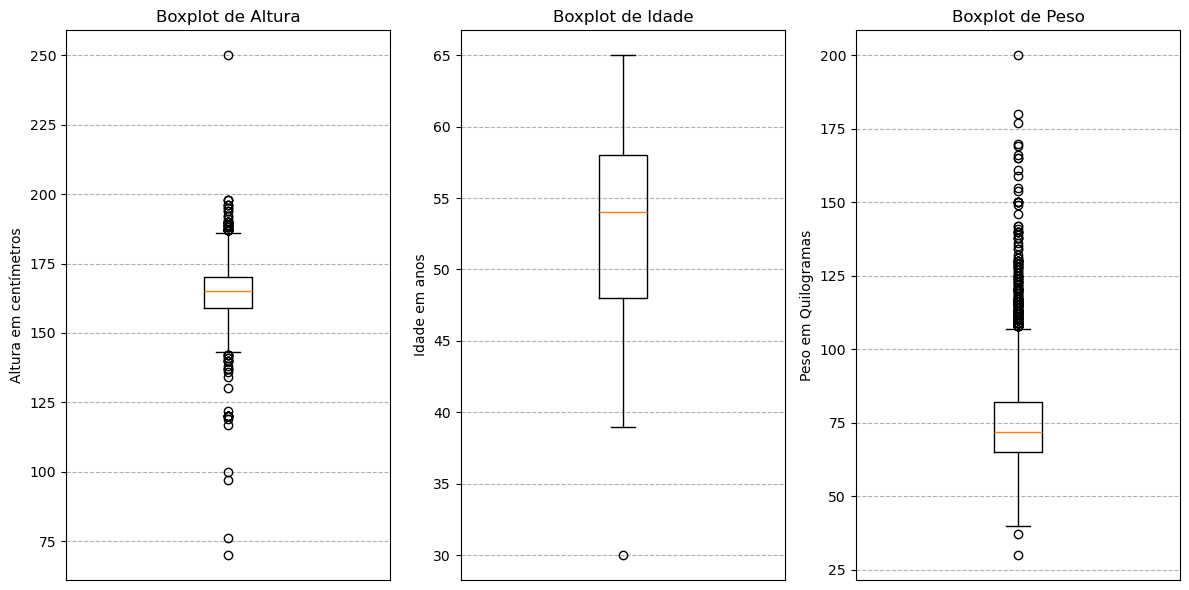

In [10]:
# Plotando o gráfico da altura
fig, axes = plt.subplots(1, 3, figsize=(12, 6)) # 1 linha, 3 colunas

# Primeiro gráfico
axes[0].boxplot(base['height'])
axes[0].set_title('Boxplot de Altura')
axes[0].set_ylabel('Altura em centímetros')
axes[0].set_xticks([])
axes[0].grid(axis='y', linestyle='--')

# Segundo gráfico
axes[1].set_title('Boxplot de Idade')
axes[1].boxplot(base['age'])
axes[1].set_ylabel('Idade em anos')
axes[1].set_xticks([])
axes[1].grid(axis='y', linestyle='--')

# Terceiro gráfico
axes[2].set_title('Boxplot de Peso')
axes[2].boxplot(base['weight'])
axes[2].set_ylabel('Peso em Quilogramas')
axes[2].set_xticks([])
axes[2].grid(axis='y', linestyle='--')

# Mostra os gráficos
plt.tight_layout()
plt.show()

Traçamos aqui três boxplots para `height`, `age` e `weight`. Podemos observar que não há crianças na base de dados. 250 centímetros de altura é improvável, como também valores abaixo de 125 centímetros (desconsiderando anomalias). Além disso, temos pessoas muito leves, como abaixo do _quartil inferior_ do gráfico. Neste caso, podemos filtrar alguns dados para ser mais acertivo.  
Não vamos desconsiderar pessoas de 200Kg, pois elas existem, e como se trata de uma base de dados para doenças cardiovasculares, acho interessante mantê-la na análise.

In [ ]:
filtro_altura = (base['height'] >= 140) & (base['height'] <= 200)
base_tratada = base[filtro_altura]

# Calculando os quartis e os intervalos
Q1 = base_tratada['weight'].quantile(0.25)
Q3 = base_tratada['weight'].quantile(0.75)
IQR = Q3 - Q1

# Definindo o limite inferior
limite_inferior = Q1 - 1.5 * IQR

# Filtrando apenas os valores acima do limite inferior
filtro_iqr_inferior = base_tratada['weight'] >= limite_inferior
base_tratada = base_tratada[filtro_iqr_inferior]

# Atualizando a base sendo utilizada
base = base_tratada.copy()
base.describe()

,age,gender,height,weight,cholesterol,gluc,smoke,alco,active,cardio_disease
count,9617.000000,9617.000000,9617.000000,9617.000000,9617.000000,9617.000000,9617.000000,9617.000000,9617.000000,9617.000000
mean,53.304773,1.351877,164.411875,74.541655,1.377041,1.229489,0.092129,0.055839,0.792243,0.508683
std,6.812971,0.477581,7.906244,14.644821,0.685363,0.572937,0.289222,0.229622,0.405723,0.499951
min,30.000000,1.000000,140.000000,40.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,1.000000,159.000000,65.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,54.000000,1.000000,165.000000,72.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
75%,58.000000,2.000000,170.000000,82.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,65.000000,2.000000,198.000000,200.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


# 2) Agora é hora de explorar os dados com uma análise bem completa.
Plote pelo menos 3 gráficos analisando o comportamento da variável cardio com outras variaveis da sua preferência (análise bivariada). Não se esqueça de trazer insights acerca do analisado.


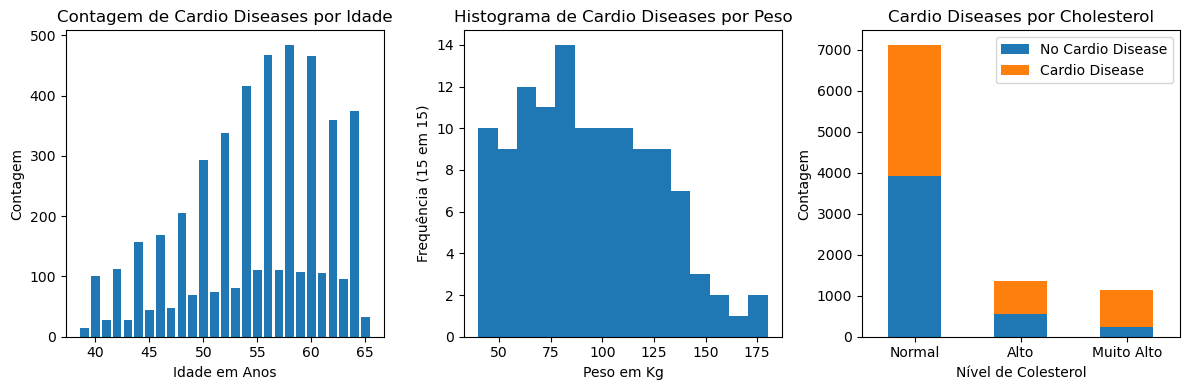

In [ ]:
# Filtrando pessoas que tem doenças cardiovasculares
base_cardio = base[base['cardio_disease'] == 1]

# Agrupando para análise bivariada
cardio_por_idade = base_cardio.groupby('age')['cardio_disease'].count().reset_index(name='qtd')
cardio_por_peso = base_cardio.groupby('weight')['cardio_disease'].count().reset_index(name='qtd')
cardio_por_cholesterol = base.groupby('cholesterol')['cardio_disease'].value_counts().unstack()

# Criação de subplots para 3 gráficos em linha
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Gráfico 1
axes[0].bar(cardio_por_idade['age'], cardio_por_idade['qtd'])
axes[0].set_ylabel('Contagem')
axes[0].set_xlabel('Idade em Anos')
axes[0].set_title('Contagem de Cardio Diseases por Idade')

# Gráfico 2
axes[1].hist(cardio_por_peso['weight'], bins=15)
axes[1].set_ylabel('Frequência (15 em 15)')
axes[1].set_xlabel('Peso em Kg')
axes[1].set_title('Histograma de Cardio Diseases por Peso')

# Gráfico 3
cardio_por_cholesterol.plot(kind='bar', stacked=True, ax=axes[2])
axes[2].set_title('Cardio Diseases por Cholesterol')
axes[2].set_ylabel('Contagem')
axes[2].set_xlabel('Nível de Colesterol')
axes[2].legend(['No Cardio Disease', 'Cardio Disease'])
axes[2].set_xticklabels(['Normal', 'Alto', 'Muito Alto'], rotation=0)

# Ajustando os espaçamentos e exibindo os gráficos
plt.tight_layout()
plt.show()

- **Gráfico 1 - Contagem de Cardio Diseases por Idade:** A partir dos 50 anos de idade, a contagem de doenças cardiovasculares sobe significantemente, mostrando uma correlação para com idade e doenças cardiovasculares.
- **Gráfico 2 - Histograma de Cardio Diseases por Peso:** A maioria da spessoas se concentra entre 60 e 120kg apesar de termos dados de pessoas com maior peso. Isso demonstra que pode ter correlação, mas não tão positiva.
- **Gráfico 3 - Cardio Diseases por Cholesterol:** Para o colesterol de nível 1 (Normal), temos a grande maioria de pessoas com doenças cardiovasculares, não isentando o nível normal de não ter doenças do coração. A porcentagem de quem tem doenças cardiovasculares entre colesterol Alto e Muito Alto são maiores, indicando correlação positiva.

# 3) Nessa etapa você deve trazer a matriz de correlação e apontar insights acerca das variáveis com um relacionamento mais forte entre si.



In [13]:
# seu código aqui

# 4) Essa é a sua última etapa pré modelo. Você deve:

A) Separar a base em treino e teste.

B) Você considera que essa base precisa que os dados sejam padronizados? Se sim, porque? Se acredita que devem, então realize essa etapa.

C) Verifique se os dados estão balanceados, se não, faça o balanceamento.


D) Visualize as bases de treino, teste (X E Y) e verifique se está tudo adequado.

In [14]:
# seu código aqui

# 5) Realize a etapa de treinamento do modelo:

A) Faça o treinamento do modelo.

B) Traga o intercept e os coeficientes.

c) Avalie as métricas do modelo treinado

D) Justifique se te parece que o modelo tem feito boas previsões ou não.

In [15]:
# seu código aqui

# 6) Teste seu modelo!

A) Aplique o modelo aos dados de teste.

B) Avalie as métricas do modelo treinado

C) Plote o gráfico da curva AUC-ROC e explique o que consegue analisar através do gráfico.

In [16]:
# seu código aqui

# 7) Explique:

A) Explique com suas palavras regressão logistica.

B) Explique porque a regressão logistica é um modelo de classificação.

C) Explique quais pontos em comum a regressão logistica tem da regressão linear.



In [17]:
# seu código aqui